<a href="https://colab.research.google.com/github/asmaamuhamed20/water-segmentation/blob/main/image_segmentation_satalite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split

import os

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

import tifffile as tiff

from PIL import Image

In [ ]:
print(" Images files:", len(os.listdir('/content/drive/MyDrive/satalite_data/images')))
print(" Labels files:", len(os.listdir('/content/drive/MyDrive/satalite_data/labels')))

 Images files: 306
 Labels files: 306


In [ ]:
images_path = "/content/drive/MyDrive/satalite_data/images"
labels_path = "/content/drive/MyDrive/satalite_data/labels"

In [ ]:
!pip install tifffile

In [ ]:
image_path = '/content/drive/MyDrive/satalite_data/images/0.tif'
mask_path = '/content/drive/MyDrive/satalite_data/labels/0.png'

In [ ]:
image = tiff.imread(image_path)   # shape → (128, 128, 12) - multispectral image  12 layres information
mask = Image.open(mask_path).convert('L')  # grayscale
mask = np.array(mask)

print( image.shape)
print( mask.shape)

(128, 128, 12)
(128, 128)


In [ ]:
image_files = [os.path.splitext(f)[0] for f in os.listdir(images_path) if f.endswith('.tif')]
label_files = [os.path.splitext(f)[0] for f in os.listdir(labels_path) if f.endswith('.png')]

image_set = set(image_files)
label_set = set(label_files)

matched = image_set.intersection(label_set)
missing_labels = image_set - label_set
extra_labels = label_set - image_set

print(f"Matching pairs: {len(matched)}")
if extra_labels:
    print(f"Labels with no matching images: {len(extra_labels)}")
    print(list(extra_labels)[:5])

Matching pairs: 306


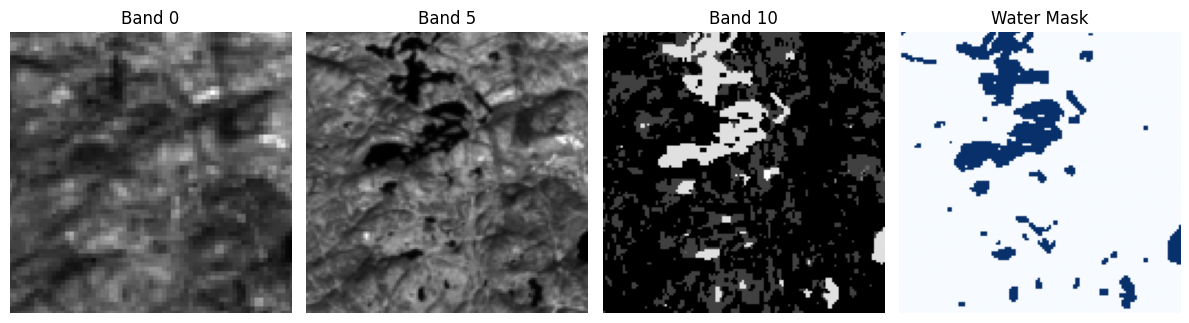

In [ ]:
plt.figure(figsize=(12, 4))


for i in range(12):
    plt.subplot(1, 4, i+1)
    plt.imshow(image[:, :, band], cmap='gray')
    plt.title(f'Band {band}')
    plt.axis('off')


plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='Blues')
plt.title('Water Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("Min value:", np.min(image))    # image shape: (128,128,12)
print("Max value:", np.max(image))

Min value: -28
Max value: 4975


In [ ]:
image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.png')])

image_names = set([os.path.splitext(f)[0] for f in image_files])
label_names = set([os.path.splitext(f)[0] for f in label_files])

matched_names = sorted(list(image_names.intersection(label_names)))

all_images = []
all_labels = []

for name in matched_names:
    image_path = os.path.join(images_path, name + '.tif')
    label_path = os.path.join(labels_path, name + '.png')

    image = tiff.imread(image_path)

    image_normalized = np.zeros_like(image, dtype=np.float32)
    for i in range(12):
        band = image[:, :, i]
        min_val = band.min()
        max_val = band.max()
        if max_val - min_val != 0:
            image_normalized[:, :, i] = (band - min_val) / (max_val - min_val)


    mask = Image.open(label_path).convert('L')
    mask = np.array(mask, dtype=np.uint8)

    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    all_images.append(image_normalized)
    all_labels.append(mask)

images = np.array(all_images, dtype=np.float32)
labels = np.array(all_labels, dtype=np.uint8)

print(f"Final dataset shapes:")
print(f"images shape: {images.shape}")
print(f"labels shape: {labels.shape}")

np.save('images.npy', images)
np.save('labels.npy', labels)

Final dataset shapes:
images shape: (306, 128, 128, 12)
labels shape: (306, 128, 128, 1)


In [ ]:
images = np.load('images.npy')
labels = np.load('labels.npy')

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation shape: {X_val.shape}, {Y_val.shape}")

Train shape: (244, 128, 128, 12), (244, 128, 128, 1)
Validation shape: (62, 128, 128, 12), (62, 128, 128, 1)


In [ ]:
def unet_model(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)

    # Encoder  - sizing
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder - skip concatenations
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model = unet_model(input_shape=(128, 128, 12))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      3,488 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_21[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 384)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    442,496 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_24[0][0] 

 Total params: 1,949,473 (7.44 MB)

 Trainable params: 1,949,473 (7.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=16
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 867ms/step - accuracy: 0.6953 - loss: 0.6403 - val_accuracy: 0.8907 - val_loss: 0.3232
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.8647 - loss: 0.3735 - val_accuracy: 0.9028 - val_loss: 0.2676
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8828 - loss: 0.3080 - val_accuracy: 0.9108 - val_loss: 0.2477
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8924 - loss: 0.2834 - val_accuracy: 0.9143 - val_loss: 0.2332
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8986 - loss: 0.2610 - val_accuracy: 0.9160 - val_loss: 0.2231
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8996 - loss: 0.2610 - val_accuracy: 0.9145 - val_loss: 0.2295
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9040 - loss: 0.2534 - val_accuracy: 0.9179 - val_loss: 0.2062
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9095 - loss: 0.2287 - val_accuracy: 0.9176 - val_loss:

In [ ]:
model.evaluate(X_val, Y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9237 - loss: 0.1707


[0.16974349319934845, 0.9243055582046509]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(1, 128, 128, 12))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


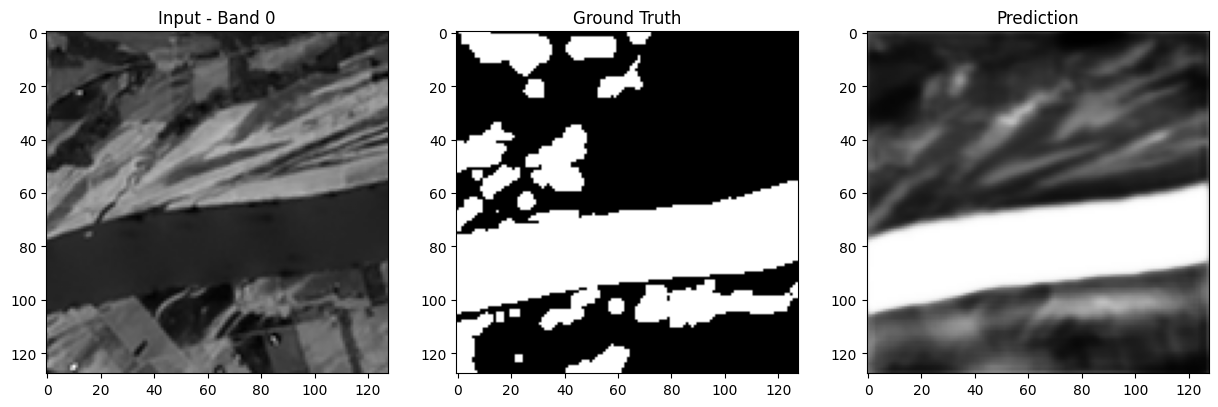

In [ ]:
i = 10

pred = model.predict(X_val[i:i+1])[0] #

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(X_val[i][:,:,0], cmap='gray')
plt.title("Input - Band 0")

plt.subplot(1,3,2)
plt.imshow(Y_val[i].squeeze(), cmap='gray')
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Prediction")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
IoU score = 0.00


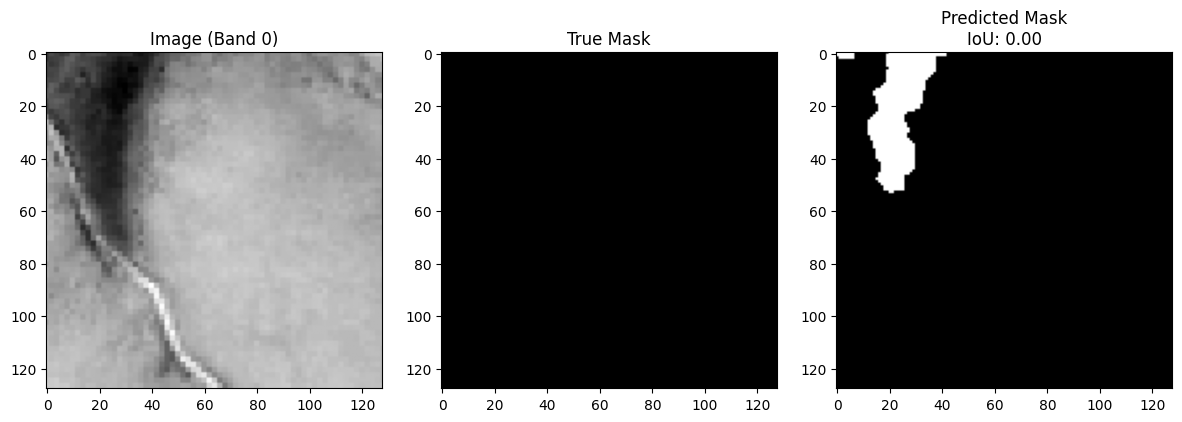

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i = 5

img = X_val[i]
true_mask = Y_val[i]

pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

score = iou(true_mask.squeeze(), pred_mask_bin.squeeze())
print(f"IoU score = {score:.2f}")

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img[:, :, 0], cmap='gray')
plt.title('Image (Band 0)')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_bin.squeeze(), cmap='gray')
plt.title(f'Predicted Mask\nIoU: {score:.2f}')

plt.tight_layout()
plt.show()